In [36]:
import numpy as np 
import scipy.stats as st 
from queue import *
import math
from distances import *
from statistics import mean 
import matplotlib.pyplot as plt


In [54]:

class Event: 
    def __init__( self, time ):
        self.time = time   
    def __lt__( self, other ):
        return self.time < other.time  
    def handle( self ):
        """updates the global simulation clock time to the class's current time attribute
        preconditions: none"""
        global simulationclock
        simulationclock = self.time
    
class NewRequest(Event, object): #An arrival occurs 
    def __init__( self, time):
        """creates a new object of class NewRequest and sets the class time attribute to the time argument
        Preconditions: time is the desired simulation clock time of the NewRequest"""
        super(NewRequest, self).__init__( time )
    def __lt__( self, other ):
        return self.time < other.time   
    def handle( self ):
   
        super(NewRequest, self).handle() # inherit operations in the function in the base class, simulation clock updated to the time when the arrival event occurs
        center = getBC()
        # request = Request(nextId, center, simulationclock, None )
        request = Request(center, simulationclock, None )
        # nextId += 1 
        eventlist.put( NewRequest( simulationclock + arrivaltime() ) )
        closest_mechanic_center, distance = closest_available_mechanic(request.center, bc_list)
        if closest_mechanic_center == None:
            requestQueue.append(request) 
        elif closest_mechanic_center == DispatchCenter: 
            DispatchCenter.num_mechs -= 1
            eventlist.put(mech_Arrives(simulationclock+(distance/60), request.center, request)) 
        else: 
            eventlist.put(mech_Arrives(simulationclock+(distance/60), request.center, request))
            closest_mechanic_center.free_mechanics -= 1
            closest_mechanic_center.number_of_mechanics -=1


class mech_Arrives(Event, object): 
    def __init__(self, time, business_center, request): 
        super(mech_Arrives, self).__init__(time)
        self.business_center = business_center
        self.request = request
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self):
        """update the global simulation time to the event time, schedule the end of the diagnosis for 
        diagnosis_time later, and increase the number of busy mechanics at the business center by 1"""
        super(mech_Arrives, self).handle()
        self.request.time_responded = (simulationclock - self.request.timeEntered)*60
        time_to_respond_avg.append(self.request.time_responded) if simulationclock>t else None
        diag_time = diagnosis_Time(self.business_center)
        self.business_center.number_of_mechanics += 1 
        eventlist.put(diag_ends(simulationclock+ diag_time, self.business_center))
        
        

class diag_ends(Event, object):
    def __init__(self, time, business_center):
        super(diag_ends, self).__init__(time)
        self.business_center = business_center
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self):
        super(diag_ends, self).handle()
        BC_prob = np.random.uniform(0,1)
        options = ['repair', 'replace']
        outcome_probabilities = np.array([0.8195, 0.1805])

        outcome = np.random.choice(options, 1, p = outcome_probabilities)[0]   
        if outcome == 'repair':
            eventlist.put(repair_start(simulationclock, self.business_center))
        else:
            eventlist.put(call_van(simulationclock, self.business_center))

class repair_start(Event, object): 
    def __init__(self, time, business_center): 
        super(repair_start, self).__init__(time)
        self.business_center = business_center
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self): 
        super().handle()
        repair_time = st.beta.rvs(2.6158007964976218, 7.460626334186162, -0.0077049330279426054, 1.557915557823419, size=1)[0]
        #repair_time = st.beta.rvs(3, 8, -0.0077049330279426054, 1.557915557823419, size=1)[0]
        #repair_time = st.rayleigh.rvs(0.0013399745442049282, 0.31486846900358867)
        eventlist.put(repair_end(simulationclock+ repair_time, self.business_center))


class repair_end(Event, object):
    def __init__(self, time, business_center): 
        super(repair_end, self).__init__(time)
        self.business_center = business_center
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self): 
        super(repair_end, self).handle()
        eventlist.put(mechanic_leaves_business_center(simulationclock, self.business_center))           

            
class mech_goes_to_dispatch(Event,object): 
    def __init__(self, time):
        super(mech_goes_to_dispatch,self).__init__(time)
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self):
        super(mech_goes_to_dispatch,self).handle()
        DispatchCenter.num_mechs += 1
        if len(requestQueue>0):
            req = requestQueue[0]
            requestQueue.remove(req)
            dist = distances.at['Dis', req.center.name]
            travel_time = dist/60
            eventlist.put(mech_Arrives(simulationclock+travel_time, req.center, req))
            DispatchCenter.num_mechs -= 1
            

        


####### REPLAACEMENT STARTS HERE
class call_van(Event,object):
    def __init__(self, time, business_center):
        super().__init__( time )
        self.business_center = business_center
    def handle(self):
        super(call_van,self).handle()
        copier_request =  Request(self.business_center, simulationclock, None)
        if DispatchCenter.available_vans > 0: 
            DispatchCenter.available_vans -= 1 
            dist = distances.at['Dis', copier_request.center.name]
            travel_time = dist/60
            eventlist.put(van_arrives_at_bc(simulationclock+travel_time, self.business_center, copier_request))           
        else:
            copierQueue.put(copier_request)
        eventlist.put(mechanic_leaves_business_center(simulationclock, self.business_center))           


class mechanic_leaves_business_center(Event, object):
    def __init__(self, time, business_center):
        super().__init__( time )
        self.business_center = business_center
    def handle(self):
        if len(requestQueue)==0:
            self.business_center.free_mechanics += 1
        else: 
            req = closest_request(self.business_center)
            dist = distances.at[req.center.name, self.business_center.name]
            travel_time = dist/60
            eventlist.put(mech_Arrives(simulationclock+travel_time, req.center, req))
            self.business_center.number_of_mechanics -= 1 

            
     
                
class van_arrives_at_bc(Event, object):
    def __init__(self, time, business_center, copier_request ):
        super().__init__( time )
        self.business_center = business_center
        self.copier_request = copier_request
    def handle(self):
        super(van_arrives_at_bc, self).handle()
        eventlist.put(van_returns_to_dispatch(simulationclock+swaptime_customer(), self.business_center, self.copier_request))
        


class van_returns_to_dispatch(Event, object):
    def __init__(self, time, business_center, copier_request):
        super().__init__(time)
        self.business_center = business_center
        self.copier_request = copier_request
    def handle(self):
        super(van_returns_to_dispatch, self).handle()
        self.copier_request.time_responded = (simulationclock - self.copier_request.timeEntered)*60
        copier_req_times.append(self.copier_request.time_responded) if simulationclock>t else None
        dist = distances.at['Dis', self.business_center.name]
        travel_time = dist/60 
        eventlist.put(van_swaps_copiers(simulationclock+travel_time))  

                      
class van_swaps_copiers(Event, object):
    def __init__(self, time):
        super().__init__(time)
    def handle(self):
        super(van_swaps_copiers, self).handle()
        eventlist.put(vans_finishes_swap(simulationclock + swaptime_dispatch()))
            
class vans_finishes_swap(Event, object):
    def __init__(self, time):
        super().__init__(time)
    def handle(self):
        super(vans_finishes_swap , self).handle()
        if copierQueue.empty():
            DispatchCenter.available_vans += 1
        else:
            cop_req = copierQueue.get()
            dist = distances.at['Dis', cop_req.center.name]
            travel_time = dist/60
            eventlist.put(van_arrives_at_bc(simulationclock+travel_time, cop_req.center, cop_req))
            

    

class Request(object): 
    def __init__( self, center, timeEntered, time_responded=None ):
        self.center = center
        # self.id = id      
        self.timeEntered = timeEntered
        self.time_responded = time_responded

# def arrivaltime(): #Comes from input analysis question 6  
#     global arrivalrate
#     time_of_day = simulationclock%24
#     if time_of_day < 22 and time_of_day >3: 
#         arrivalrate = (-0.067*(time_of_day**2)) + 1.581*(time_of_day) - 1.289 
#     else: 
#         arrivalrate = 1.137 
        #return np.random.exponential( 1 / arrivalrate )

def swaptime_dispatch(): #Service time to swap at the dispatch center, keeping everything in hours 
    return np.random.triangular(left=10/60, mode=15/60, right=25/60)

def swaptime_customer(): #Service time to swap at customer loctation 
    return np.random.triangular(left=20/60, mode=30/60, right = 1)
        
def diagnosis_Time(bc):
    if bc.name in ['BC_2', 'BC_3', 'BC_9']:
        return 1/60*np.random.normal(22.15, 5.34)
    else: 
        return 1/60*np.random.normal(16.13, 2.89)



def closest_available_mechanic(business_center, bc_list):
    available_mechanic_centers = []
    for x in bc_list:
        if x.free_mechanics > 0:
            available_mechanic_centers.append(x)
    if len(available_mechanic_centers)==0 and DispatchCenter.num_mechs ==0:
        return None, None
        

    if len(available_mechanic_centers)==0:
        if DispatchCenter.num_mechs > 0:
            disp_dist = distances.at['Dis', business_center.name]
            return DispatchCenter, disp_dist

        
    
    min_dist_center = available_mechanic_centers[0]
    min_dist = distances.at[min_dist_center.name, business_center.name]

    for y in available_mechanic_centers:
        dist = distances.at[y.name, business_center.name]
        if dist < min_dist:
            min_dist = dist
            min_dist_center = y
    if DispatchCenter.num_mechs != 0:
        disp_dist = distances.at['Dis', business_center.name]
        if disp_dist < min_dist:
            min_dist = disp_dist
            min_dist_center = DispatchCenter
  
    return min_dist_center, min_dist


def closest_request(BC):
    closest_req=requestQueue[0]
    closest_dist=distances.at[BC.name, closest_req.center.name]
    for req in requestQueue:
        if distances.at[BC.name, req.center.name] < closest_dist:
            closest_dist=distances.at[BC.name, req.center.name]
            closest_req=req
    requestQueue.remove(closest_req)
    return closest_req



    

In [55]:
class business_center(object):
    def __init__( self, name, coordinates, number_of_mechanics=0, number_of_vans=0, free_mechanics=0):
        self.name=name
        self.coordinates = coordinates
        self.number_of_mechanics = number_of_mechanics
        self.number_of_vans = number_of_vans
        self.free_mechanics = free_mechanics

In [56]:
class van(object):
    def __init__( self, busy=False, current_location=0, broken=False):
        self.busy = busy
        self.current_location = current_location 
        self.broken = broken

In [57]:
class dispatch(object):
    def __init__(self, coordinates, available_vans, num_mechs):
        self.coordinates = coordinates
        self.available_vans = available_vans
        self.num_mechs = num_mechs


In [58]:
class mechanic(object):
    def __init__(self, busy=False, current_location=0):
        self.busy = busy
        self.current_location= current_location


In [66]:
bc_coords = [[6,10],[4,8],[4,6],[1,6],[1,7],[9,3],[11,3],[9,2],[9,1],[11,1]]
bc_names = ['BC_1', 'BC_2', 'BC_3', 'BC_4', 'BC_5', 'BC_6', 'BC_7', 'BC_8', 'BC_9', 'BC_10']


def getBC():
    BC_prob = np.random.uniform(0,1)
    probabilities = np.array([0.039509, 0.082089, 0.107916, 0.135418, 0.118386, 
                              0.055005, 0.123830, 0.057937, 0.137512, 0.142398])
    return np.random.choice(bc_list, 1, p = probabilities)[0]



#mean and standard errors of the estimates
mec_avgs_mean2=[]
mec_se_std2=[]
van_avgs_mean2=[]
van_se_std2=[]
t=50
T=100
B=50

# ****SENSITIVITY ANALYSIS PART****
#Looping Through Perturbed Values 
arrival_adjusts=np.linspace(start=-1,stop=1, num=50)
for j in arrival_adjusts:
    def arrivaltime(): #Comes from input analysis question 6  
        global arrivalrate
        time_of_day = simulationclock%24
        if time_of_day < 22 and time_of_day >3: 
            arrivalrate = ((-0.067)*(time_of_day**2) + (1.581)*(time_of_day) - (1.289))+j
        else: 
            arrivalrate = 1.137
        return np.random.exponential( 1 / arrivalrate )

    mec_avgs=[]
    van_avgs=[]
    for i in range(B):
        simulationclock = 0
        requestQueue = []
        copierQueue = Queue()
        avail_vans = 3
        num_mechs = 7
        DispatchCenter = dispatch([5,2], avail_vans, num_mechs)
        eventlist = PriorityQueue()
        bc_list = []
        for i in range(len(bc_coords)):
            bc_list.append(business_center(bc_names[i], bc_coords[i] , 0, 0, 0))
        a = NewRequest(0)
        eventlist.put( a )
        time_to_respond_avg = []
        copier_req_times = []
    
        while simulationclock < T:
            e = eventlist.get()
            e.handle()

        mec_avgs.append(np.mean(np.array(time_to_respond_avg)))
        van_avgs.append(np.mean(np.array(copier_req_times)))
    #keep track of mean and se
    mec_avgs_mean2.append(np.mean(np.array(mec_avgs)))
    mec_se_std2.append(np.std(np.array(mec_avgs))/np.sqrt(B))
    van_avgs_mean2.append(np.mean(np.array(van_avgs)))
    van_se_std2.append(np.std(np.array(van_avgs))/np.sqrt(B))

32.71325491944457
33.098559743547796
32.94361205550836
33.19113649341088
33.06857559063401
33.340614453767955
33.57146961957647
33.76348172621102
34.0919079712495
34.38335563172781
34.53783031204353
34.764308720090916
34.8264000232347
35.07987371782258
35.26415982052164
35.48753597617771
35.640680469480884
35.80983032118309
36.06667055713703
36.1504858714725
36.31193760448594
36.510037223834125
36.65600075870294
36.7712947303987
37.028682783955894
37.18844615545964
37.32742919581832
37.48212700957853
37.72099611493591
37.890997568084295
38.13584460070795
38.365643217413776
38.532876000993646
38.72681595751511
38.89134894371224
39.03125771246857
39.21305707787226
39.36600513582914
39.55166579246736
39.739291245927554
39.9424596568812
40.148017692200376
40.3411542020664
40.57351545095445
40.77876906559706
40.975150087092345
41.1992644956865
41.408269467233204
41.58457609915355
41.819406718246235


41.819406718246235
[32.71325491944457, 33.483864567651025, 32.6337166794295, 33.933709807118426, 32.578331979526546, 34.70080876943764, 34.95660061442758, 35.10756647265287, 36.71931793155732, 37.006384576032616, 36.08257711520078, 37.25557120861211, 35.57149566096009, 38.3750317474651, 37.844165258308564, 38.838178311018716, 38.09099236233164, 38.68537780012061, 40.689794804307915, 37.74297684384644, 39.540972264754735, 40.67012923014604, 39.867198525816804, 39.423056079401306, 43.205996069328414, 41.18253044305338, 40.940988245143856, 41.6589679811042, 44.40933106494243, 42.82103970938731, 45.481255579417535, 45.48940033529489, 43.88432507554937, 45.1268345227233, 44.485470474414576, 43.92806461894032, 45.75783423240504, 45.02508328023364, 46.606770744719604, 47.05668393087523, 48.06919609502686, 48.57589714028677, 48.45288761643944, 50.565049153140464, 49.809928109872146, 49.81229605437985, 51.50852729101751, 51.231503129928505, 50.04729443133029, 53.32610705378762]


Text(0.5, 1.0, 'Arrival Time vs. Initial Response Time')

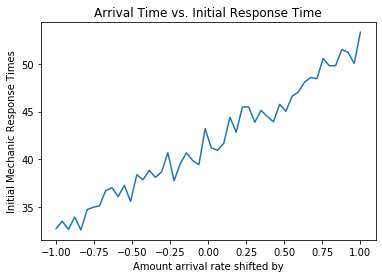

In [72]:
print(np.mean(mec_avgs_mean2))
print(mec_avgs_mean2)
plt.plot(arrival_adjusts, mec_avgs_mean2  )
plt.xlabel("Amount arrival rate shifted by")
plt.ylabel("Initial Mechanic Response Times")
plt.title("Arrival Time vs. Initial Response Time")


145.27931106063738
[119.11890575036848, 117.29117133717713, 120.24813238137902, 123.51613959046415, 118.80224567366812, 121.15413594290547, 128.85048625949898, 128.01079176727058, 132.54042156017218, 129.0063766211561, 128.8669834365731, 121.25703721939237, 134.26078518786392, 127.48367074392723, 125.9557975128377, 131.0073862670123, 132.03737561241135, 127.8714258250575, 136.6756593810327, 143.0417284903783, 131.28375677982513, 135.37124542266892, 139.37731055319097, 138.64831273031368, 147.40946233253698, 137.80669858203544, 156.34074916160174, 155.2538307226171, 143.21153722771183, 144.2601276705011, 150.89614633781923, 139.57759533926338, 142.03678285403072, 152.19638882824498, 169.6692396409953, 154.68444479899833, 161.86664724176316, 158.6007282761811, 164.62119579556997, 175.11465202472783, 161.98458430072498, 150.66168896160454, 172.05094175628398, 175.78485091635895, 179.14568772485435, 159.9204331429313, 160.06922715887825, 192.26708439780631, 177.70172675075892, 189.15581904

Text(0.5, 1.0, 'Arrival Time vs. Copier Delivery Times')

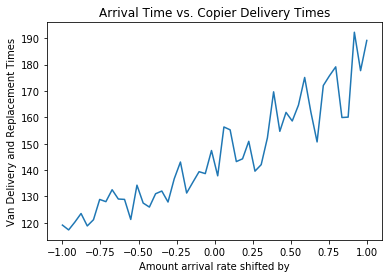

In [73]:
print(np.mean(van_avgs_mean2))
print(van_avgs_mean2)
plt.plot(arrival_adjusts, van_avgs_mean2 )
plt.xlabel("Amount arrival rate shifted by")
plt.ylabel("Van Delivery and Replacement Times")
plt.title("Arrival Time vs. Copier Delivery Times")
